# Experiments in Modeling Issue Segmentation

## Load Libraries and Datasets

In [7]:
import os
import re
import pandas as pd
from tqdm import tqdm
import altair as alt
alt.data_transformers.disable_max_rows()
from collections import deque
import warnings
warnings.filterwarnings('ignore')
from rich.console import Console
from rich.table import Table
import numpy as np
import scipy.stats as stats
from minineedle import needle, core

console = Console()
import sys

sys.path.append("..")
from segmentation_scripts.utils import read_csv_file, get_data_directory_path

In [2]:
full_df = read_csv_file("../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038071/mdp_39015056038071_annotated_individual_tokens.csv")
console.print(f"Volume has this many tokens: {len(full_df)}")
console.print(f"Volume has this many issues: {full_df.start_issue.nunique()}")
console.print(f"Volume has this many pages: {full_df.page_number.nunique()}")
# Factorize the 'issue_number' column to create 'actual_issue_number'
full_df = full_df.sort_values(by=['page_number'])
full_df = full_df.rename(columns={'issue_number': 'original_issue_number'})
full_df['temp_issue_number'] = pd.factorize(full_df['original_issue_number'])[0]

Volume has this many tokens: 300791

Volume has this many issues: 26

Volume has this many pages: 907

In [3]:
def generate_table(df, table_title):
    # Create a Rich Table
    table = Table(title=table_title)
    columns = df.columns
    for column in columns:
        table.add_column(column.replace("_", " ").capitalize(), justify="center", style="cyan", no_wrap=True)    

    # Add rows to the table
    for _, row in df.iterrows():
        table.add_row(*[str(value) if pd.notna(value) else "" for value in row])

    # Print the table
    console.print(table)

### Clean Page Numbers

In [4]:
def filter_integers(token: str) -> bool:
	"""Check if the token is an integer."""
	return bool(re.match(r'^\d+$', token))

def clean_digits(df: pd.DataFrame) -> pd.DataFrame:
	"""Clean and filter digit tokens in the DataFrame while retaining non-digit pages."""
	max_page = df.page_number.max()
	
	df['token'] = df['token'].astype(str)
	if 'volume_name' in df.columns:
		df['volume_number'] = df['volume_number'].fillna(0)
	
	# Identify pages with digit tokens
	subset_digits = df[df['token'].str.isdigit()].copy()
	possible_pages = subset_digits[subset_digits['token'].apply(filter_integers)].copy()
	non_digits_pages = df[(~df['token'].str.isdigit()) & (~df.page_number.isin(subset_digits.page_number))].copy()
	# just take the first page of non_digits_pages
	non_digits_pages = non_digits_pages.groupby('page_number').first().reset_index()
	
	# Use the smaller subset if possible_pages is smaller
	if len(possible_pages) < len(subset_digits):
		subset_digits = possible_pages
	
	console.print(f"Number of digits in this volume: {len(subset_digits)}")
	console.print(f"Number of non-digit pages in this volume: {len(non_digits_pages)}")
	
	subset_digits['number'] = subset_digits['token'].astype(int, errors='ignore')
	max_possible_number = max_page + 25
	filtered_subset_digits = subset_digits[subset_digits['number'] < max_possible_number]
	non_filtered_subset_digits = subset_digits[(subset_digits['number'] >= max_possible_number) & (~subset_digits.page_number.isin(filtered_subset_digits.page_number))].groupby('page_number').first().reset_index()
	console.print(f"Number of digits in this volume after filtering for max page length: {len(filtered_subset_digits)}")
	console.print(f"Number of pages without digits in this volume after filtering for max page length: {len(non_filtered_subset_digits)}")
	
	# Calculate implied zero only for digit pages
	filtered_subset_digits['implied_zero'] = filtered_subset_digits['page_number'].astype(int) - filtered_subset_digits['number']
	
	final_subset_digits = filtered_subset_digits[filtered_subset_digits['implied_zero'] >= 0]
	console.print(f"Number of digits in this volume after filtering for max page length and implied zero: {len(final_subset_digits)}")
	remaining_missing_pages = df[(~df.page_number.isin(final_subset_digits.page_number)) & (~df.page_number.isin(non_digits_pages.page_number))].copy()
	remaining_missing_pages = remaining_missing_pages.groupby('page_number').first().reset_index()
	console.print(f"Number of pages without digits in this volume after filtering for max page length and digit pages: {len(remaining_missing_pages)}")
	
	# Merge non-digit pages back into the DataFrame
	non_digits_pages['page_type'] = 'non_digit'
	remaining_missing_pages['page_type'] = 'negative_digit'
	final_subset_digits['page_type'] = 'digit'
	non_filtered_subset_digits['page_type'] = 'digit_too_large'
	full_df_with_digits = pd.concat([final_subset_digits, non_digits_pages, remaining_missing_pages, non_filtered_subset_digits]).sort_values(by=['page_number']).reset_index(drop=True)
	
	console.print(f"Number of pages after including non-digit pages: {full_df_with_digits.page_number.nunique()}")

	if full_df_with_digits.page_number.nunique() != full_df.page_number.nunique():
		added_pages = full_df[~full_df.page_number.isin(full_df_with_digits.page_number)].copy()
		added_pages = added_pages.groupby('page_number').first().reset_index()
		added_pages['page_type'] = 'added'
		full_df_with_digits = pd.concat([full_df_with_digits, added_pages]).sort_values(by=['page_number']).reset_index(drop=True)
		console.print(f"Number of pages after including added pages: {full_df_with_digits.page_number.nunique()}")
	
	return full_df_with_digits

# Example usage
subset_digits = clean_digits(full_df)
counts_per_annotated_issue = subset_digits.start_issue.value_counts().reset_index()
generate_table(counts_per_annotated_issue, "Counts per Annotated Issue")

Number of digits in this volume: 6885

Number of non-digit pages in this volume: 97

Number of digits in this volume after filtering for max page length: 5299

Number of pages without digits in this volume after filtering for max page length: 21

Number of digits in this volume after filtering for max page length and implied zero: 4923

Number of pages without digits in this volume after filtering for max page length and digit pages: 24

Number of pages after including non-digit pages: 907

 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1962-05-14  │  253  │
│ 1962-04-16  │  238  │
│ 1962-04-23  │  235  │
│ 1962-03-26  │  229  │
│ 1962-04-02  │  228  │
│ 1962-01-08  │  222  │
│ 1962-03-19  │  220  │
│ 1962-05-28  │  220  │
│ 1962-05-21  │  219  │
│ 1962-06-25  │  219  │
│ 1962-03-12  │  214  │
│ 1962-04-30  │  214  │
│ 1962-06-18  │  203  │
│ 1962-03-05  │  200  │
│ 1962-02-26  │  200  │
│ 1962-02-12  │  189  │
│ 1962-02-19  │  179  │
│ 1962-06-11  │  176  │
│ 1962-02-05  │  173  │
│ 1962-04-09  │  172  │
│ 1962-05-07  │  170  │
│ 1962-06-04  │  169  │
│ 1962-01-22  │  152  │
│ 1962-01-29  │  148  │
│ 1962-01-15  │  130  │
│ 1962-01-01  │  93   │
└─────────────┴───────┘

### Detect Likely First Issue

In [5]:
def run_global_sequence_alignment(window: list, target_sequence: list, placeholder: int = -1) -> tuple:
    """Apply global sequence alignment on the implied zero values within a window using minineedle, with placeholders."""
    observed_sequence = [int(p[1]) if pd.notna(p[1]) else placeholder for p in window]
    
    # Check for valid entries in the observed sequence
    if all(val == placeholder for val in observed_sequence):
        return 0, [], []

    # Create Needleman-Wunsch global alignment instance
    alignment = needle.NeedlemanWunsch(observed_sequence, target_sequence)
    alignment.change_matrix(core.ScoreMatrix(match=4, miss=-0.5, gap=-1))

    try:
        # Run the alignment
        alignment.align()
        aligned_observed, aligned_target = alignment.get_aligned_sequences(core.AlignmentFormat.list)
        alignment_score = alignment.get_score()
        return alignment_score, aligned_observed, aligned_target

    except ZeroDivisionError:
        return 0, [], []

def sequence_alignment_issue_detection_global(df: pd.DataFrame, threshold_sizes: list, placeholder: int = -1) -> pd.DataFrame:
    """Detect issue boundaries using global sequence alignment."""
    df['page_number'] = df['page_number'].astype(int)
    df = df.sort_values(by=['page_number', 'implied_zero'])

    all_boundaries = []

    for threshold_size in tqdm(range(threshold_sizes[0], threshold_sizes[1]), desc="Threshold Sizes"):
        target_sequence = list(range(1, threshold_size + 1))  # Generate the target sequence
        first_page_number = df.page_number.min()
        final_page_number = df[df.page_number == first_page_number + threshold_size].page_number.max()
        
        for additional_page in range(5):
            current_first_page_number = first_page_number + additional_page
            selected_rows = df[(df.page_number <= final_page_number) & (df.page_number >= current_first_page_number)]
            potential_sequence = list(zip(selected_rows['page_number'], selected_rows['implied_zero']))
            
            # Run sequence alignment with placeholders
            alignment_score, aligned_observed, aligned_target = run_global_sequence_alignment(potential_sequence, target_sequence, placeholder=placeholder)
            
            # Analyze the alignment score
            if alignment_score >= (0.6 * threshold_size):  # Adjust this threshold as needed
                all_boundaries.append((alignment_score, aligned_observed, aligned_target, threshold_size, current_first_page_number, final_page_number))

    boundaries_df = pd.DataFrame(all_boundaries, columns=['alignment_score', 'aligned_observed', 'aligned_target', 'threshold_size', 'start_page', 'end_page'])
    return boundaries_df


# Example usage
likely_first_issue_boundaries_df = sequence_alignment_issue_detection_global(subset_digits, threshold_sizes=[10, 200], placeholder=-1)

Threshold Sizes:   0%|          | 0/190 [00:00<?, ?it/s]

Threshold Sizes: 100%|██████████| 190/190 [00:56<00:00,  3.37it/s]


In [8]:
top_ten_boundaries = likely_first_issue_boundaries_df.sort_values(by=['alignment_score', 'start_page'], ascending=[False, True]).head(10)
generate_table(top_ten_boundaries[['alignment_score', 'threshold_size', 'start_page', 'end_page']], "Top Ten Likely First Issue Boundaries")

           Top Ten Likely First Issue Boundaries            
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Alignment score ┃ Threshold size ┃ Start page ┃ End page ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━┩
│      31.0       │      36.0      │    8.0     │   43.0   │
│      31.0       │      36.0      │    9.0     │   43.0   │
│      30.5       │      37.0      │    8.0     │   44.0   │
│      30.5       │      37.0      │    9.0     │   44.0   │
│      29.5       │      36.0      │    7.0     │   43.0   │
│      29.0       │      37.0      │    7.0     │   44.0   │
│      27.5       │      34.0      │    8.0     │   41.0   │
│      27.5       │      34.0      │    9.0     │   41.0   │
│      26.0       │      34.0      │    7.0     │   41.0   │
│      25.0       │      15.0      │    8.0     │   22.0   │
└─────────────────┴────────────────┴────────────┴──────────┘

In [15]:
def select_likely_first_issue(df: pd.DataFrame, mean_threshold: float) -> pd.Series:
    """Select the most likely first issue based on weighted scores."""
    # Calculate frequency of start_page, end_page, and threshold_size
    start_page_freq = df['start_page'].value_counts(normalize=True).to_dict()
    end_page_freq = df['end_page'].value_counts(normalize=True).to_dict()
    threshold_size_freq = df['threshold_size'].value_counts(normalize=True).to_dict()

    # Define weights
    alpha, beta, gamma, delta = 0.4, 0.2, 0.2, 0.2

    # Add a column for weighted score
    def calculate_weighted_score(row):
        alignment_score = row['alignment_score']
        start_page_score = start_page_freq.get(row['start_page'], 0)
        end_page_score = end_page_freq.get(row['end_page'], 0)
        threshold_diff = abs(row['threshold_size'] - mean_threshold)
        threshold_score = 1 - (threshold_diff / mean_threshold)

        return (alpha * alignment_score +
                beta * start_page_score +
                gamma * end_page_score +
                delta * threshold_score)

    df['weighted_score'] = df.apply(calculate_weighted_score, axis=1)

    # Select the candidate with the highest weighted score
    best_candidate = df.sort_values(by='weighted_score', ascending=False).iloc[0]

    return best_candidate

def calculate_confidence_interval(df: pd.DataFrame, column: str, confidence: float = 0.95) -> tuple:
    """Calculate the confidence interval for a given column."""
    mean_val = df[column].mean()
    std_dev = df[column].std()
    n = len(df)

    # Calculate standard error
    standard_error = std_dev / np.sqrt(n)

    # Calculate confidence interval
    z_score = stats.norm.ppf((1 + confidence) / 2)
    margin_of_error = z_score * standard_error

    lower_bound = mean_val - margin_of_error
    upper_bound = mean_val + margin_of_error

    return mean_val, lower_bound, upper_bound, margin_of_error


# Calculate the mean of threshold sizes
mean_threshold = top_ten_boundaries['threshold_size'].mean()

# Apply the selection function to the top ten boundaries
best_first_issue = select_likely_first_issue(top_ten_boundaries, mean_threshold)
best_first_issue_df = pd.DataFrame([best_first_issue]).reset_index(drop=True)
generate_table(best_first_issue_df[['alignment_score', 'threshold_size', 'start_page', 'end_page']], "Best First Issue Candidate")

# Calculate confidence intervals for threshold_size and alignment_score
mean_threshold, lower_threshold, upper_threshold, margin_error_threshold = calculate_confidence_interval(top_ten_boundaries, 'threshold_size')
mean_score, lower_score, upper_score, margin_error_score = calculate_confidence_interval(top_ten_boundaries, 'alignment_score')

console.print(f"Threshold Size: Mean = {mean_threshold}, CI = ({lower_threshold}, {upper_threshold}), Margin of Error = {margin_error_threshold}", style="bold")
console.print(f"Alignment Score: Mean = {mean_score}, CI = ({lower_score}, {upper_score}), Margin of Error = {margin_error_score}", style="bold")


                 Best First Issue Candidate                 
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Alignment score ┃ Threshold size ┃ Start page ┃ End page ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━┩
│      31.0       │      36.0      │    8.0     │   43.0   │
└─────────────────┴────────────────┴────────────┴──────────┘

Threshold Size: Mean = 33.6, CI = (29.47630533223672, 37.72369466776328), Margin of Error = 4.123694667763282

Alignment Score: Mean = 28.75, CI = (27.417080383304743, 30.082919616695257), Margin of Error = 1.3329196166952577

### Detect Remaining Issues

In [15]:
def probabilistic_issue_detection(df: pd.DataFrame, window_size: int = 5, threshold_sizes: list = [30]) -> pd.DataFrame:
    """Detect issue boundaries probabilistically without relying on annotations."""

    df['page_number'] = df['page_number'].astype(int)
    df['implied_zero'] = df['implied_zero'].astype(int, errors='ignore')
    df = df.sort_values(by=['page_number'])

    # Initialize list to store detected boundaries across all thresholds
    all_boundaries = []

    for threshold in tqdm(threshold_sizes, desc="Threshold Sizes"):
        # Initialize deque to maintain a sliding window of page numbers for each threshold
        sliding_window = deque(maxlen=window_size)
        # Initialize list to store detected boundaries for this threshold
        issue_boundaries = []
        issue_number = 0
        existing_start_issue = None

        page_numbers = df['page_number'].unique().tolist()
        for index, page_number in tqdm(enumerate(page_numbers), desc="Page Numbers", total=len(page_numbers)):
            selected_rows = df[df['page_number'] == page_number]
            implied_zero_values = selected_rows[(selected_rows.implied_zero.notna()) & (selected_rows.page_type == "digit")]['implied_zero'].tolist()
            is_digit_page = selected_rows['page_type'].values[0]

            if index == 0:
                existing_start_issue = selected_rows['start_issue'].values[0]

            # Update the sliding window
            if is_digit_page == "digit":
                for implied_zero in implied_zero_values:
                    sliding_window.append((page_number, implied_zero))
            else:
                sliding_window.append((page_number, None))

            # Check boundaries when window is full
            if len(sliding_window) == window_size:
                page_range = max(p[0] for p in sliding_window if p[1] is not None) - min(p[0] for p in sliding_window if p[1] is not None)
                implied_zero_diff = max(p[1] for p in sliding_window if p[1] is not None) - min(p[1] for p in sliding_window if p[1] is not None)

                # Probabilistic scoring for boundary detection
                score = 0
                if page_range > threshold:
                    score += 0.5
                    # If the page range exceeds the threshold, add to score by 0.5. 

                if implied_zero_diff > threshold:
                    score += 0.5
                    # If the implied zero difference exceeds the threshold, add to score by 0.5.

                # Check if non-digit pages contribute to score
                non_digit_count = sum(1 for p in sliding_window if p[1] is None)
                if non_digit_count > 0:
                    score += 0.2 * (non_digit_count / window_size)
                    # If non-digit pages are present, add to score by 0.2 for each non-digit page.

                # Flag boundary if score is sufficient
                if score > 0:
                    issue_boundaries.append((
                        page_number, implied_zero_values, 'potential_boundary',
                        selected_rows['start_issue'].values[0], issue_number, threshold, selected_rows['temp_issue_number'].values[0], is_digit_page
                    ))

            # Increment issue_number for a new start_issue
            if existing_start_issue != selected_rows['start_issue'].values[0]:
                issue_number += 1
                existing_start_issue = selected_rows['start_issue'].values[0]

        # Print summary after each threshold
        all_boundaries.extend(issue_boundaries)

    # Create DataFrame for all boundaries
    boundaries_df = pd.DataFrame(all_boundaries, columns=['page_number', 'implied_zero_values', 'status', 'start_issue', 'status_issue_number', 'threshold', 'temp_issue_number', 'page_type'])

    # Calculate probabilistic weights for each threshold
    boundaries_df['boundary_prob'] = boundaries_df.groupby('threshold')['page_number'].transform('count') / len(df['page_number'].unique())

    return boundaries_df

# Example usage with a more focused range of thresholds
range_of_max_issue_length = [20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]
boundaries_df = probabilistic_issue_detection(subset_digits, threshold_sizes=range_of_max_issue_length)

# Analyze results
console.print(f"Detected {len(boundaries_df)} potential boundaries across {len(boundaries_df.threshold.unique())} thresholds.")



Threshold Sizes: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


Detected 6883 potential boundaries across 13 thresholds.

In [60]:
output = subset_digits[(subset_digits.page_number >= 1) & (subset_digits.page_number <= 30)][['number', 'implied_zero', 'page_number', 'page_type', 'section']].sort_values(by=['page_number', 'implied_zero']).to_dict(orient='records')
import pyperclip
pyperclip.copy(str(output))

In [12]:
# def advanced_sequence_detection(df: pd.DataFrame, threshold: int = 30, score_threshold: float = 0.5) -> pd.DataFrame:
#     """Detect issue boundaries using sequential scoring and section-based weighting."""

#     df['page_number'] = df['page_number'].astype(int)
#     df['implied_zero'] = df['implied_zero'].astype(int, errors='ignore')
#     df = df.sort_values(by=['page_number'])

#     # Initialize list to store detected boundaries
#     issue_boundaries = []
#     max_score = 0

#     page_numbers = df['page_number'].unique().tolist()

#     # Slide window across the pages, based on the specified threshold size
#     for start_page in tqdm(range(0, len(page_numbers) - threshold + 1), desc="Sliding Window"):

#         # Define window range
#         window_pages = page_numbers[start_page:start_page + threshold]
#         window_df = df[df['page_number'].isin(window_pages)]

#         # Initialize variables for scoring
#         seq_digits = 0  # Number of digits forming a sequence
#         total_digits = 0  # Total number of digits in the window
#         pages_with_digits = 0  # Number of pages containing digits
#         section_score = 0  # Section-based weighting
#         missing_pages = 0  # Number of pages without digits

#         # Calculate the sequence score within the window
#         for _, row in window_df.iterrows():
#             digit = row['number'] if row['page_type'] == 'digit' else None
#             section = row['section']

#             if digit is not None:
#                 total_digits += 1
#                 # Check if digit is part of a plausible sequence
#                 print(total_digits)
#                 if (total_digits > 1) and (abs(digit - previous_digit) <= 1):
#                     seq_digits += 1  # Increment if digits form a sequence

#                 # Apply section-based weighting
#                 if section != "body":
#                     section_score += 0.2  # Higher weight for headers/footers

#             else:
#                 missing_pages += 1  # Increment for pages without digits

#             previous_digit = digit  # Update for next iteration

#         # Calculate final score for the window
#         sequence_score = (seq_digits / total_digits) if total_digits > 0 else 0
#         page_density_score = pages_with_digits / threshold
#         missing_page_penalty = (missing_pages / threshold) * 0.1  # Small penalty for missing pages
#         total_score = sequence_score + page_density_score + section_score - missing_page_penalty

#         # Flag boundary if total score exceeds threshold
#         if total_score >= score_threshold:
#             end_page = window_pages[-1]
#             issue_boundaries.append((end_page, total_score, 'potential_boundary'))
#             max_score = max(max_score, total_score)  # Track the highest score

#     # Create DataFrame for detected boundaries
#     boundaries_df = pd.DataFrame(issue_boundaries, columns=['page_number', 'boundary_score', 'status'])
#     return boundaries_df

# # Example usage
# threshold_size = 30  # Example threshold
# advanced_boundaries_df = advanced_sequence_detection(subset_digits, threshold=threshold_size, score_threshold=0.5)

# # Analyze results
# console.print(f"Detected {len(advanced_boundaries_df)} potential boundaries.")
# console.print(advanced_boundaries_df.head())

In [21]:
def updated_probabilistic_issue_detection(df: pd.DataFrame, window_size: int = 5, threshold_sizes: list = [30], score_threshold: float = 0.5) -> pd.DataFrame:
	"""Detect issue boundaries probabilistically without relying on annotations."""

	df['page_number'] = df['page_number'].astype(int)
	df['implied_zero'] = df['implied_zero'].astype(int, errors='ignore')
	df = df.sort_values(by=['page_number'])

	# Initialize list to store detected boundaries across all thresholds
	all_boundaries = []

	for threshold in tqdm(threshold_sizes, desc="Threshold Sizes"):
		sliding_window = deque(maxlen=window_size)
		issue_boundaries = []
		issue_number = 0
		existing_start_issue = None

		page_numbers = df['page_number'].unique().tolist()
		cumulative_score = 0  # Use cumulative scoring

		for index, page_number in tqdm(enumerate(page_numbers), desc="Page Numbers", total=len(page_numbers)):
			selected_rows = df[df['page_number'] == page_number]
			implied_zero_values = selected_rows[(selected_rows.implied_zero.notna()) & (selected_rows.page_type == "digit")][['implied_zero', 'section']].to_dict(orient='records')
			is_digit_page = selected_rows['page_type'].values[0]

			if index == 0:
				existing_start_issue = selected_rows['start_issue'].values[0]

			# Update the sliding window
			if is_digit_page == "digit":
				for implied_zero_dict in implied_zero_values:
					implied_zero = implied_zero_dict['implied_zero']
					section_weight = 0.2 if implied_zero_dict['section'] != "body" else 0
					sliding_window.append((page_number, implied_zero, section_weight))
			else:
				sliding_window.append((page_number, None, 0))

			# Check boundaries when window is full
			if len(sliding_window) == window_size:
				page_range = max(p[0] for p in sliding_window if p[1] is not None) - min(p[0] for p in sliding_window if p[1] is not None)
				implied_zero_diff = max(p[1] for p in sliding_window if p[1] is not None) - min(p[1] for p in sliding_window if p[1] is not None)

				# Adjust weights for boundary detection
				score = 0
				if page_range > threshold:
					score += 0.6  # Increased weight for page range

				if implied_zero_diff > threshold:
					score += 0.4  # Increased weight for implied zero diff

				# Increase weight of non-digit pages in the score
				non_digit_count = sum(1 for p in sliding_window if p[1] is None)
				if non_digit_count > 0:
					score += 0.3 * (non_digit_count / window_size)  # Increase weight for non-digit pages
					
				# Increase weight of section headers in the score
				section_weight = sum(p[2] for p in sliding_window)
				if section_weight > 0:
					score += 0.1 * section_weight

				# Use cumulative scoring
				cumulative_score += score

				# Flag boundary if cumulative score is sufficient
				if cumulative_score >= score_threshold:
					issue_boundaries.append((
						page_number, implied_zero_values, 'potential_boundary',
						selected_rows['start_issue'].values[0], issue_number, threshold, selected_rows['temp_issue_number'].values[0], is_digit_page
					))
					cumulative_score = 0  # Reset cumulative score after detecting a boundary

			# Increment issue_number for a new start_issue
			if existing_start_issue != selected_rows['start_issue'].values[0]:
				issue_number += 1
				existing_start_issue = selected_rows['start_issue'].values[0]

		# Print summary after each threshold
		all_boundaries.extend(issue_boundaries)

	# Create DataFrame for all boundaries
	boundaries_df = pd.DataFrame(all_boundaries, columns=['page_number', 'implied_zero_values', 'status', 'start_issue', 'status_issue_number', 'threshold', 'temp_issue_number', 'page_type'])

	# Calculate probabilistic weights for each threshold
	boundaries_df['boundary_prob'] = boundaries_df.groupby('threshold')['page_number'].transform('count') / len(df['page_number'].unique())

	return boundaries_df

# Example usage with adjusted score threshold and weighting
range_of_max_issue_length = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]
updated_boundaries_df = updated_probabilistic_issue_detection(subset_digits, threshold_sizes=range_of_max_issue_length, score_threshold=0.5)

# Analyze results
console.print(f"Detected {len(updated_boundaries_df)} potential boundaries across {len(updated_boundaries_df.threshold.unique())} thresholds.")

Threshold Sizes: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


Detected 4381 potential boundaries across 16 thresholds.

In [22]:
# Calculate average boundary probability across status_issue_number and threshold
avg_boundary_prob_df = updated_boundaries_df.groupby(['status_issue_number', 'threshold']).boundary_prob.mean().reset_index()

# Add a likelihood column that represents the probability of a boundary for each issue
avg_boundary_prob_df = avg_boundary_prob_df.rename(columns={'boundary_prob': 'avg_boundary_prob'})
avg_boundary_prob_df['likelihood'] = avg_boundary_prob_df['avg_boundary_prob']


# Display the average boundary probabilities
console.print(avg_boundary_prob_df)

# Visualize the likelihood distribution across thresholds and status_issue_number
chart = alt.Chart(avg_boundary_prob_df).mark_line(point=True).encode(
    x='status_issue_number:O',
    y='likelihood:Q',
    color='threshold:N',
    tooltip=['status_issue_number', 'threshold', 'likelihood']
).properties(
    title='Average Boundary Probability Across Status Issue Number and Threshold'
)

chart

status_issue_number  threshold  avg_boundary_prob  likelihood
0                      0          5           0.510474    0.510474
1                      0         10           0.489526    0.489526
2                      0         15           0.459757    0.459757
3                      0         20           0.416759    0.416759
4                      0         25           0.366042    0.366042
..                   ...        ...                ...         ...
411                   25         60           0.231533    0.231533
412                   25         70           0.213892    0.213892
413                   25         80           0.196251    0.196251
414                   25         90           0.175303    0.175303
415                   25        100           0.153252    0.153252

[416 rows x 4 columns]

alt.Chart(...)

In [12]:
# def detect_issue_boundaries(df: pd.DataFrame, window_size: int = 5, threshold_sizes: list = [30]) -> pd.DataFrame:
#     """Detect issue boundaries in the dataset using a sliding window approach, while retaining non-digit pages.

#     Args:
#         df (pd.DataFrame): The input DataFrame containing page numbers and implied zeros.
#         window_size (int): The size of the sliding window.
#         threshold_sizes (list): A list of threshold sizes to detect boundaries.

#     Returns:
#         pd.DataFrame: A DataFrame containing detected boundaries.
#     """
#     # Prepare the DataFrame by ensuring necessary columns are integers
#     df['page_number'] = df['page_number'].astype(int)
#     df['implied_zero'] = df['implied_zero'].astype(int, errors='ignore')
    
#     # Sort by page_number for sequential window analysis
#     df = df.sort_values(by=['page_number'])
    
#     # Initialize list to store detected boundaries across all thresholds
#     all_boundaries = []
    
#     for threshold in tqdm(threshold_sizes, desc="Threshold Sizes"):
#         # Initialize deque to maintain a sliding window of page numbers for each threshold
#         sliding_window = deque(maxlen=window_size)
        
#         # Initialize list to store detected boundaries for this threshold
#         issue_boundaries = []
#         issue_number = 0
#         existing_start_issue = None
        
#         page_numbers = df['page_number'].unique().tolist()
        
#         for index, page_number in tqdm(enumerate(page_numbers), desc="Page Numbers", total=len(page_numbers)):
#             selected_rows = df[df['page_number'] == page_number]
#             implied_zero_values = selected_rows['implied_zero'].tolist()
#             print('implied_zero_values', implied_zero_values)
#             is_digit_page = selected_rows['is_digit_page'].values[0]
#             print('is_digit_page', is_digit_page)
            
#             if index == 0:
#                 existing_start_issue = selected_rows['start_issue'].values[0]
            
#             # Update the sliding window with each unique page and its implied zeros, including non-digit pages
#             if is_digit_page:
#                 for implied_zero in implied_zero_values:
#                     sliding_window.append((page_number, implied_zero))
#             else:
#                 sliding_window.append((page_number, None))  # Use None for non-digit pages
            
#             # Check for boundary conditions only if window is full
#             if len(sliding_window) == window_size:
#                 print(sliding_window)
#                 page_range = max(p[0] for p in sliding_window if p[1] is not None) - min(p[0] for p in sliding_window if p[1] is not None)
#                 implied_zero_diff = max(p[1] for p in sliding_window if p[1] is not None) - min(p[1] for p in sliding_window if p[1] is not None)


#                 # If the page range or implied zero diff exceeds the threshold, flag a potential boundary
#                 if page_range > threshold or implied_zero_diff > threshold:
#                     issue_boundaries.append((page_number, implied_zero_values, 'potential_boundary', selected_rows['start_issue'].values[0], issue_number, threshold, selected_rows['temp_issue_number'].values[0]))
            
#             # Only increment issue_number when a new start_issue is encountered and not the same as the existing one
#             if existing_start_issue != selected_rows['start_issue'].values[0]:
#                 issue_number += 1
#                 existing_start_issue = selected_rows['start_issue'].values[0]
        
#         # Append results for this threshold to all boundaries outside of page loop
#         all_boundaries.extend(issue_boundaries)
    
#     # Create DataFrame for all boundaries with threshold as a column
#     boundaries_df = pd.DataFrame(all_boundaries, columns=['page_number', 'implied_zero_values', 'status', 'start_issue', 'status_issue_number', 'threshold', 'temp_issue_number'])
#     return boundaries_df

# # Example usage with multiple threshold sizes
# range_of_max_issue_length = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 200, 300]
# boundaries_df = detect_issue_boundaries(subset_digits, threshold_sizes=range_of_max_issue_length)

# # Display results
# console.print(f"Detected this many potential boundaries: {len(boundaries_df)} across this many thresholds: {len(boundaries_df.threshold.unique())}")

In [13]:
# def detect_issue_boundaries(df: pd.DataFrame, window_size: int = 5, threshold_sizes: list = [30]) -> pd.DataFrame:
#     """Detect issue boundaries in the dataset using a sliding window approach.

#     Args:
#         df (pd.DataFrame): The input DataFrame containing page numbers and implied zeros.
#         window_size (int): The size of the sliding window.
#         threshold_sizes (list): A list of threshold sizes to detect boundaries.

#     Returns:
#         pd.DataFrame: A DataFrame containing detected boundaries.
#     """
#     # Prepare the DataFrame by ensuring necessary columns are integers
#     df['page_number'] = df['page_number'].astype(int)
#     df['implied_zero'] = df['implied_zero'].astype(int)
    
#     # Sort by page_number for sequential window analysis
#     df = df.sort_values(by=['page_number'])
    
#     # Initialize list to store detected boundaries across all thresholds
#     all_boundaries = []
    
#     for threshold in tqdm(threshold_sizes, desc="Threshold Sizes"):
#         # Initialize deque to maintain a sliding window of page numbers for each threshold
#         sliding_window = deque(maxlen=window_size)
        
#         # Initialize list to store detected boundaries for this threshold
#         issue_boundaries = []
#         issue_number = 0
#         existing_start_issue = None
        
#         page_numbers = df['page_number'].unique().tolist()
        
#         for index, page_number in tqdm(enumerate(page_numbers), desc="Page Numbers", total=len(page_numbers)):
#             selected_rows = df[df['page_number'] == page_number]
#             implied_zero_values = selected_rows['implied_zero'].tolist()
            
#             if index == 0:
#                 existing_start_issue = selected_rows['start_issue'].values[0]
            
#             # Update the sliding window with each unique page and its implied zeros
#             for implied_zero in implied_zero_values:
#                 sliding_window.append((page_number, implied_zero))
                
#             # Check for boundary conditions only if window is full
#             if len(sliding_window) == window_size:
#                 print(sliding_window)
#                 page_range = max(p[0] for p in sliding_window) - min(p[0] for p in sliding_window)
#                 implied_zero_diff = max(p[1] for p in sliding_window) - min(p[1] for p in sliding_window)
                
#                 if page_range > threshold or implied_zero_diff > threshold:
#                     # Append only once per page with existing page details and current threshold
#                     issue_boundaries.append((page_number, implied_zero_values, 'potential_boundary', selected_rows['start_issue'].values[0], issue_number, threshold, selected_rows['temp_issue_number'].values[0]))
            
#             # Only increment issue_number when a new start_issue is encountered and not the same as the existing one
#             if existing_start_issue != selected_rows['start_issue'].values[0]:
#                 issue_number += 1
#                 existing_start_issue = selected_rows['start_issue'].values[0]
        
#         # Append results for this threshold to all boundaries outside of page loop
#         all_boundaries.extend(issue_boundaries)
    
#     # Create DataFrame for all boundaries with threshold as a column
#     boundaries_df = pd.DataFrame(all_boundaries, columns=['page_number', 'implied_zero_values', 'status', 'start_issue', 'status_issue_number', 'threshold', 'temp_issue_number'])
#     return boundaries_df

# # Example usage with multiple threshold sizes
# range_of_max_issue_length = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 200, 300]
# subset_digits = subset_digits.sort_values(by=['page_number'])
# boundaries_df = detect_issue_boundaries(subset_digits, threshold_sizes=range_of_max_issue_length)

# # Display results
# print(f"Detected this many potential boundaries: {len(boundaries_df)} across this many thresholds: {len(boundaries_df.threshold.unique())}")
# print("Detected potential boundaries per threshold:\n", boundaries_df.groupby(['threshold']).size())

In [12]:
correspondence_df = boundaries_df.groupby(['threshold', 'start_issue']).apply(
    lambda x: (x['status_issue_number'] == x['temp_issue_number']).mean()
).reset_index(name='correspondence')

chart = alt.Chart(correspondence_df).mark_point(filled=True).encode(
    x='start_issue:T',
    y='correspondence:Q',
	color='threshold:N',
    tooltip=['threshold', 'correspondence', 'start_issue:T']
).properties(
    title='Correspondence between status_issue_number and temp_issue_number by Threshold'
)

chart

alt.Chart(...)

In [13]:
# Calculate mean, standard deviation, variance, and coefficient of variation
stats_df = correspondence_df.groupby('threshold').correspondence.aggregate(
    mean='mean',
    std='std',
    var='var',
    cv=lambda x: x.std() / x.mean()
).reset_index()

stats_df

,threshold,mean,std,var,cv
0,20,0.967323,0.007398,0.000055,0.007648
1,25,0.963427,0.008683,0.000075,0.009012
2,30,0.959754,0.013828,0.000191,0.014408
3,35,0.957851,0.014633,0.000214,0.015276
4,40,0.954807,0.016763,0.000281,0.017556
5,45,0.953090,0.017777,0.000316,0.018652
6,50,0.950827,0.019749,0.000390,0.020770
7,55,0.949561,0.020388,0.000416,0.021471
8,60,0.947783,0.021794,0.000475,0.022995
9,70,0.944051,0.024008,0.000576,0.025431


In [35]:
# Initialize Raw Scores Function
def initialize_raw_scores(df):
    max_page = df['page_number'].max()
    max_possible_number = max_page + 25
    raw_scores = np.zeros((max_page + 1, max_possible_number + 1), dtype=int)

    raw_scores_counter = 0
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Initializing Raw Scores"):
        page = int(row['page_number'])
        number = int(row['number']) if row['page_type'] == 'digit' else 0  # Set non-digit numbers to 0
        
        # Check if indices are within bounds
        if 0 <= page <= max_page and 0 <= number <= max_possible_number:
            raw_scores[page, number] += 1
            raw_scores_counter += 1
        else:
            console.print(f"Skipped out-of-bounds entry at page {page}, number {number}")

    return raw_scores

# Prefix Sum Calculation
def prefix_sums(raw_scores, updown=0.5, diag=0.25, otherwise=0.01, points=1.0):  # Increased points to 1.0
    scores = raw_scores.copy()
    nrows, ncols = raw_scores.shape

    for i in range(nrows):
        for j in range(ncols):
            cell = otherwise + points * raw_scores[i, j]
            choices = []
            if j > 0:
                choices.append(scores[i, j-1] * updown)
            if i > 0:
                choices.append(scores[i-1, j] * updown)
                if j > 0:
                    choices.append(scores[i-1, j-1] * diag)
            cell += max(choices, default=0)
            scores[i, j] = cell
            # Debug: Print accumulated score for first few rows/columns
            if i < 5 and j < 5:
                console.print(f"Score at [{i},{j}]: {cell}")

    return scores

# Combine Forward and Backward Passes
def combined_scores(raw_scores, backpass_weight=0.66):
    forward = prefix_sums(raw_scores)
    backward = prefix_sums(raw_scores[::-1, :])[::-1, :]
    combined = backpass_weight * backward + (1 - backpass_weight) * forward
    return combined

# Predict Boundaries Using Combined Scores
def predict_boundaries_prefix_sum(combined_scores):
    predictions = []
    for i in range(combined_scores.shape[0]):
        max_score_idx = np.argmax(combined_scores[i])
        score_at_max = combined_scores[i, max_score_idx]

        # Flag boundaries with a minimum score threshold
        if score_at_max > 0:  # Adjust this condition if needed
            predictions.append((i, max_score_idx, score_at_max))

    predictions_df = pd.DataFrame(predictions, columns=['page_number', 'predicted_boundary', 'boundary_score'])
    return predictions_df

# Apply the Prefix Sum Method to the Cleaned Data
raw_scores = initialize_raw_scores(subset_digits)
combined = combined_scores(raw_scores)
prefix_sum_df = predict_boundaries_prefix_sum(combined)

console.print(f"Prefix Sum detected {len(prefix_sum_df)} potential boundaries.")
console.print(prefix_sum_df.head())

Initializing Raw Scores: 100%|██████████| 5065/5065 [00:00<00:00, 29739.01it/s]


Score at [0,0]: 0.01

Score at [0,1]: 0.01

Score at [0,2]: 0.01

Score at [0,3]: 0.01

Score at [0,4]: 0.01

Score at [1,0]: 0.01

Score at [1,1]: 0.01

Score at [1,2]: 0.01

Score at [1,3]: 0.01

Score at [1,4]: 0.01

Score at [2,0]: 0.01

Score at [2,1]: 0.01

Score at [2,2]: 0.01

Score at [2,3]: 0.01

Score at [2,4]: 0.01

Score at [3,0]: 0.01

Score at [3,1]: 0.01

Score at [3,2]: 0.01

Score at [3,3]: 0.01

Score at [3,4]: 0.01

Score at [4,0]: 0.01

Score at [4,1]: 0.01

Score at [4,2]: 0.01

Score at [4,3]: 0.01

Score at [4,4]: 0.01

Score at [0,0]: 1.01

Score at [0,1]: 0.51

Score at [0,2]: 0.01

Score at [0,3]: 0.01

Score at [0,4]: 0.01

Score at [1,0]: 0.51

Score at [1,1]: 0.26

Score at [1,2]: 0.01

Score at [1,3]: 0.01

Score at [1,4]: 0.01

Score at [2,0]: 0.01

Score at [2,1]: 0.01

Score at [2,2]: 0.01

Score at [2,3]: 0.01

Score at [2,4]: 0.01

Score at [3,0]: 0.01

Score at [3,1]: 0.01

Score at [3,2]: 0.01

Score at [3,3]: 0.01

Score at [3,4]: 0.01

Score at [4,0]: 0.01

Score at [4,1]: 0.01

Score at [4,2]: 0.01

Score at [4,3]: 0.01

Score at [4,4]: 0.01

Prefix Sum detected 912 potential boundaries.

page_number  predicted_boundary  boundary_score
0            7                   1             1.0
1            9                   1             1.0
2           10                   0             1.0
3           11                   0             1.0
4           12                   1             2.0

In [36]:
prefix_sum_df.sort_values(by=['page_number', 'predicted_boundary']).head(10)

,page_number,predicted_boundary,boundary_score
0,7,1,1.00
1,9,1,1.00
2,10,0,1.00
3,11,0,1.00
4,12,1,2.00
5,13,1,1.34
6,14,1,1.34
7,15,1,1.34
8,16,8,1.00
9,17,1,1.00


In [42]:
subset_full_df = full_df[['page_number', 'start_issue', 'type_of_page', 'temp_issue_number']].copy().drop_duplicates()
merged_prefix_sum_df = prefix_sum_df.merge(subset_full_df, on='page_number', how='left').sort_values(by=['page_number', 'predicted_boundary']).head(10)

In [46]:
import altair as alt
import pandas as pd

# Merge actual issues with predicted boundary scores
merged_prefix_sum_df = prefix_sum_df.merge(
    subset_full_df[['page_number', 'start_issue', 'temp_issue_number']], 
    on='page_number', 
    how='left'
)

# Calculate a rolling average of boundary scores over a window of pages
window_size = 5  # Adjust this window size as needed
merged_prefix_sum_df['rolling_avg_score'] = merged_prefix_sum_df['boundary_score'].rolling(window=window_size, min_periods=1).mean()

# Add a category column to separate actual and predicted boundaries in the plot
merged_prefix_sum_df['category'] = 'Predicted'
merged_prefix_sum_df.loc[merged_prefix_sum_df['start_issue'].notna(), 'category'] = 'Actual'

# Base chart for page number
base = alt.Chart(merged_prefix_sum_df).encode(
    x=alt.X('page_number:Q', title='Page Number')
)

# Line for the rolling average of boundary scores
rolling_avg_line = base.mark_line(color='blue').encode(
    y=alt.Y('rolling_avg_score:Q', title='Rolling Average Score'),
    tooltip=['page_number', 'rolling_avg_score']
).properties(
    title='Actual vs. Predicted Issue Boundaries'
)

# Points for actual and predicted boundaries
boundary_points = base.mark_point(filled=True).encode(
    y=alt.Y('category:N', title='Boundary Type', scale=alt.Scale(domain=['Actual', 'Predicted'])),
    color=alt.Color('category:N', scale=alt.Scale(domain=['Actual', 'Predicted'], range=['red', 'green'])),
    shape=alt.Shape('category:N', scale=alt.Scale(domain=['Actual', 'Predicted'], range=['cross', 'circle'])),
    tooltip=['page_number', 'start_issue', 'boundary_score']
)

# Combine all layers
chart = (rolling_avg_line + boundary_points).interactive()

# Display the chart
chart

alt.LayerChart(...)

In [45]:
import altair as alt
import pandas as pd

# Ensure the necessary columns are of the correct data type
prefix_sum_df['page_number'] = prefix_sum_df['page_number'].astype(int)
subset_full_df['page_number'] = subset_full_df['page_number'].astype(int)

# Merge actual issues with predicted boundary scores
merged_prefix_sum_df = prefix_sum_df.merge(
    subset_full_df[['page_number', 'start_issue', 'temp_issue_number']], 
    on='page_number', 
    how='left'
)

# Calculate a rolling average of boundary scores over a window of pages
window_size = 5  # Adjust this window size as needed
merged_prefix_sum_df['rolling_avg_score'] = merged_prefix_sum_df['boundary_score'].rolling(window=window_size, min_periods=1).mean()

# Base chart for page number
base = alt.Chart(merged_prefix_sum_df).encode(
    x=alt.X('page_number:Q', title='Page Number')
)

# Line for the rolling average of boundary scores
rolling_avg_line = base.mark_line(color='blue').encode(
    y=alt.Y('rolling_avg_score:Q', title='Rolling Average Score'),
    tooltip=['page_number', 'rolling_avg_score']
).properties(
    title='Actual vs. Predicted Issue Boundaries'
)

# Points for actual issue boundaries
actual_points = base.transform_filter(
    alt.datum.start_issue != None  # Only show rows with actual boundaries
).mark_point(
    color='red', size=80, shape='cross'
).encode(
    y=alt.value(1.2),  # Place above the rolling average line
    tooltip=['page_number', 'start_issue', 'temp_issue_number']
)

# Points for predicted boundaries
predicted_points = base.transform_filter(
    alt.datum.boundary_score > 0  # Only show positive boundary scores
).mark_circle(color='green', size=50).encode(
    y=alt.Y('boundary_score:Q'),
    tooltip=['page_number', 'boundary_score', 'temp_issue_number']
)

# Combine all layers
chart = (rolling_avg_line + actual_points + predicted_points).interactive()

# Display the chart
chart

alt.LayerChart(...)

In [34]:
# # Prefix Sum Method
# def initialize_raw_scores(df):
# 	max_page = df['page_number'].max()
# 	max_possible_number = max_page + 25
# 	raw_scores = np.zeros((max_page + 1, max_possible_number + 1), dtype=int)
	
# 	raw_scores_counter = 0
# 	for _, row in tqdm(df.iterrows(), total=len(df), desc="Initializing Raw Scores"):
# 		page = row['page_number']
# 		number = row['number']
# 		if number <= max_possible_number:
# 			raw_scores[page, number] += 1
# 			raw_scores_counter += 1
# 	console.print(f"Initialized raw scores for {raw_scores_counter} digits across {max_page} pages from an initial {len(df)} digits.")
# 	return raw_scores

# def prefix_sums(raw_scores, updown=0.5, diag=0.25, otherwise=0.01, points=0.2):
# 	scores = raw_scores.copy()
# 	nrows, ncols = raw_scores.shape
# 	for i in range(nrows):
# 		for j in range(ncols):
# 			cell = otherwise + points * raw_scores[i, j]
# 			choices = []
# 			if j > 0:
# 				choices.append(scores[i, j-1] * updown)
# 			if i > 0:
# 				choices.append(scores[i-1, j] * updown)
# 				if j > 0:
# 					choices.append(scores[i-1, j-1] * diag)
# 			cell += max(choices, default=0)
# 			scores[i, j] = cell
# 	console.print(f"Computed prefix sums for {nrows} rows and {ncols} columns.")
# 	console.print(f"Max score: {scores.max()}")
# 	return scores

# def combined_scores(raw_scores, backpass_weight=0.66):
# 	forward = prefix_sums(raw_scores)
# 	backward = prefix_sums(raw_scores[::-1, :])[::-1, :]
# 	return backpass_weight * backward + (1 - backpass_weight) * forward

# def predict_boundaries_prefix_sum(combined_scores):
# 	predictions = []
# 	for i in range(combined_scores.shape[0]):
# 		max_score_idx = np.argmax(combined_scores[i])
# 		predictions.append((i, max_score_idx))  # (page_number, predicted_boundary)
# 	predictions_df = pd.DataFrame(predictions, columns=['page_number', 'predicted_boundary'])
# 	return predictions_df


# # Prefix Sum Predictions
# raw_scores = initialize_raw_scores(subset_digits)
# combined = combined_scores(raw_scores)
# prefix_sum_df = predict_boundaries_prefix_sum(combined)
# console.print(f"Prefix Sum detected {len(prefix_sum_df)} potential boundaries.")

In [13]:
prefix_sum_df.predicted_boundary.value_counts().head(10)

predicted_boundary
0    948
Name: count, dtype: int64

In [8]:
# Merge Results for Comparison
comparison_df = pd.merge(boundaries_df, prefix_sum_df, on='page_number', how='outer', suffixes=('_sliding', '_prefix'))
comparison_df.head()

,page_number,implied_zero_values,status,start_issue,status_issue_number,threshold,predicted_boundary
0,0,NaN,NaN,NaN,NaN,NaN,0
1,1,NaN,NaN,NaN,NaN,NaN,0
2,2,NaN,NaN,NaN,NaN,NaN,0
3,3,NaN,NaN,NaN,NaN,NaN,0
4,4,NaN,NaN,NaN,NaN,NaN,0


In [55]:
def get_predicted_page(df, range_of_max_issue_length, window_size=2):
    dfs = []
    
    for max_issue_length in tqdm(range_of_max_issue_length, desc="Predicting Page Number"):
        copied_df = df.copy()
        max_page = copied_df['page_number'].max()
        max_possible_number = max_page + max_issue_length
        
        filtered_df = copied_df[copied_df['number'] < max_possible_number]
        
        grouped_pages = filtered_df.groupby('implied_zero').size().reset_index(name='counts')
        grouped_pages = grouped_pages[grouped_pages['counts'] > max_issue_length - 5].reset_index(drop=True)
        
        # Pre-allocate columns with `None`
        copied_df = copied_df.assign(predicted_page=None, predicted_issue_number=None, max_issue_length=max_issue_length)
        for index, row in grouped_pages.iterrows():
            # Using vectorized operations to assign predictions
            zero_window = [max(0, row.implied_zero - window_size), row.implied_zero + window_size]
            zero_range = range(zero_window[0], zero_window[1] + 1)
            
            is_within_window = copied_df['page_number'].isin(zero_range)
            copied_df.loc[is_within_window, 'predicted_page'] = 'predicted_beginning_of_issue'
            copied_df.loc[is_within_window, 'predicted_issue_number'] = f"issue {index}"
        
        dfs.append(copied_df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

range_of_max_issue_length = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 200, 300]
predicted_df = get_predicted_page(merged_boundaries_digits_df, range_of_max_issue_length)

Predicting Page Number: 100%|██████████| 16/16 [00:00<00:00, 31.77it/s]


In [68]:
predicted_df[predicted_df.status == "potential_boundary"][['start_issue', 'predicted_page', 'predicted_issue_number', 'status', 'max_issue_length', 'page_number']].drop_duplicates()

,start_issue,predicted_page,predicted_issue_number,status,max_issue_length,page_number
0,1962-04-16,predicted_beginning_of_issue,issue 230,potential_boundary,10,549
24,1962-04-16,predicted_beginning_of_issue,issue 230,potential_boundary,10,550
33,1962-04-16,predicted_beginning_of_issue,issue 231,potential_boundary,10,552
36,1962-04-16,predicted_beginning_of_issue,issue 232,potential_boundary,10,553
45,1962-04-16,predicted_beginning_of_issue,issue 232,potential_boundary,10,554


In [7]:
### Annotated Datasets

def get_annotated_datasets(df, range_of_max_issue_length, rewrite_files):
       predictions_path = "../issue_segments/predicted_issue_segments_for_annotated_issues.csv"
       issues_path = "../derived_annotated_datasets/issue_segments_for_annotated_issues.csv"
       if (os.path.exists(predictions_path)) and (os.path.exists(issues_path)) and (rewrite_files == False):
              predictions = pd.read_csv(predictions_path)
              final_df = pd.read_csv(issues_path)
       else:
              subset_digits = clean_digits(df)
              tqdm.pandas()
              htids = subset_digits.htid.unique().tolist()
              dfs = []
              for htid in tqdm(htids, total=len(htids), desc='Processing digits'):
                     subset_df = subset_digits[subset_digits.htid == htid]
                     subset_df = get_predicted_page(subset_df, range_of_max_issue_length)
                     dfs.append(subset_df)
              combined_subset_digits = pd.concat(dfs)
              combined_subset_digits = combined_subset_digits.reset_index(drop=True)
              digit_cols = combined_subset_digits.columns.tolist()
              digit_cols = [x for x in digit_cols if x not in ['pos', 'count', 'section', 'token']]
              combined_subset_digits = combined_subset_digits[digit_cols]
              cols = list(set(df) & (set(combined_subset_digits)))
              

              merged_df = pd.merge(df, combined_subset_digits, on=cols, how='left')
              if merged_df['volume_number'].isna().all():
                     merged_df = merged_df.drop(columns='volume_number')
              cols = cols + ['predicted_page', 'predicted_issue_number', 'max_issue_length']
              subset_predictions = combined_subset_digits[cols].drop_duplicates()
              subset_predictions = subset_predictions[(subset_predictions.type_of_page == 'cover_page') & (subset_predictions.predicted_page.notna())]
              pages_cols = merged_df.columns.tolist()
              holdout_cols = ['section', 'token', 'pos', 'count', 'number', 'implied_zero']
              pages_cols = [x for x in pages_cols if x not in holdout_cols]
              pages_df = merged_df[pages_cols]
              pages_df = pages_df.drop_duplicates()
              groupby_cols = ['cleaned_magazine_title', 'ht_generated_title', 'volume_number', 'htid', 'hdl_link','cleaned_volume', 'start_issue', 'end_issue', 'datetime','dates', 'issue_number', 'type_of_page', 'sequence'] if 'volume_number' in merged_df.columns else ['cleaned_magazine_title', 'ht_generated_title', 'htid', 'hdl_link','cleaned_volume', 'start_issue', 'end_issue', 'datetime','dates', 'issue_number', 'type_of_page', 'sequence']
              final_df = merged_df.groupby(groupby_cols, as_index = False).agg({'token': ' '.join, 'count': list, 'number': list, 'implied_zero': list})
              final_cols = list(set(pages_df) & set(final_df))
              finalized_df = pd.merge(pages_df, final_df, on=final_cols, how='left')
              all_predictions = finalized_df[finalized_df.predicted_page.notna()]
              grouped_df = df.groupby(groupby_cols, as_index = False).agg({'token': ' '.join})
              pred_cols = list(set(grouped_df) & set(subset_predictions))

              pred_merged_df = pd.merge(grouped_df, subset_predictions, on=pred_cols, how='left')
              # predictions.to_csv(predictions_path, index=False)
              # finalized_df.to_csv(issues_path, index=False)
       return finalized_df, all_predictions, pred_merged_df

In [10]:
def get_annotations(large_files, initial_df, range_of_max_issue_length, rewrite_files):
    if large_files == True:
        # annotated_dfs = []
        all_predictions_dfs = []
        predictions_dfs = []
        for directory, subdir, files in os.walk("derived_files/temp/"):
            for file in tqdm(files, desc="Files"):
                # if file.startswith("issue_segments_for_annotated_issues"):
                #     annotated_df = pd.read_csv(f"{directory}/{file}")
                #     annotated_dfs.append(annotated_df)
                if (file.startswith("predicted_issue_segments_for_annotated_issues")) and ('merged' not in file):
                    all_predictions = pd.read_csv(f"{directory}/{file}")
                    all_predictions_dfs.append(all_predictions)
                elif file.startswith("predicted_issue_segments_for_annotated_issues_merged"):
                    predictions_df = pd.read_csv(f"{directory}/{file}")
                    predictions_dfs.append(predictions_df)
        # final_annotated_df = pd.concat(annotated_dfs)
        all_predictions = pd.concat(all_predictions_dfs)
        predictions_df = pd.concat(predictions_dfs)
        annotated_df = pd.DataFrame()
    else:
        annotated_df, all_predictions, predictions_df = get_annotated_datasets(initial_df, range_of_max_issue_length, rewrite_files=True)
        print(len(annotated_df[(annotated_df.type_of_page == 'cover_page') & (annotated_df.predicted_page.notna())]), len(annotated_df[(annotated_df.type_of_page == 'cover_page') & (annotated_df.predicted_page.isna())]))
        print(predictions_df[(predictions_df.predicted_page.notna()) & (predictions_df.token.str.len() < 200)][0:1].to_dict())
    return annotated_df, all_predictions, predictions_df

In [11]:
annotated_df, all_predictions, predictions_df = get_annotations(large_files=True, initial_df=initial_df, range_of_max_issue_length=range_of_max_issue_length, rewrite_files=True)

Files: 100%|██████████| 51/51 [00:28<00:00,  1.82it/s]


In [12]:
issue_count = all_predictions.groupby(['cleaned_magazine_title', 'htid', 'max_issue_length']).predicted_issue_number.nunique().reset_index()

alt.Chart(issue_count).mark_bar().encode(
    x=alt.X('sum(predicted_issue_number):Q'),
    y=alt.Y('cleaned_magazine_title:N', sort='-x'),
    row=alt.Row('max_issue_length:N'),
)

alt.Chart(...)

In [13]:
annotated_issue_count = initial_df.groupby(['cleaned_magazine_title', 'htid']).start_issue.nunique().reset_index()

alt.Chart(annotated_issue_count).mark_bar().encode(
    x=alt.X('sum(start_issue):Q'),
    y=alt.Y('cleaned_magazine_title:N', sort='-x')
)

alt.Chart(...)

In [14]:
combined_df = pd.merge(issue_count, annotated_issue_count, on=['cleaned_magazine_title', 'htid'], how='left')

melted_df = pd.melt(combined_df, id_vars=['cleaned_magazine_title', 'htid', 'max_issue_length'], value_vars=['predicted_issue_number', 'start_issue'])
melted_df.loc[melted_df.variable == 'predicted_issue_number', 'variable'] = 'Predicted Number of Issues'
melted_df.loc[melted_df.variable == 'start_issue', 'variable'] = 'Annotated Number of Issues'

In [15]:
alt.Chart(melted_df).mark_bar().encode(
    x=alt.X('sum(value):Q'),
    y=alt.Y('variable:N', sort='-x'),
    color=alt.Color('variable:N'),
    row=alt.Row('max_issue_length:N', header=alt.Header(labelAngle=0, labelAlign='left'), title=None,),
    column=alt.Column('cleaned_magazine_title:N', header=alt.Header(labelAngle=0, labelAlign='left'), title=None,),
)

alt.Chart(...)

### Experiment with Textual Features

In [16]:
import nltk
from nltk import word_tokenize, sent_tokenize

predictions_df['token'] = predictions_df.token.fillna('')
predictions_df['token'] = predictions_df.token.astype(str)
predictions_df['token_length'] = predictions_df.token.str.len()
predictions_df['tokenized_text'] = predictions_df.token.apply(word_tokenize)
predictions_df['tokenized_text_length'] = predictions_df.tokenized_text.str.len()
predictions_df['sentences'] = predictions_df.token.apply(sent_tokenize)
predictions_df['sentences_length'] = predictions_df.sentences.str.len()

In [17]:
sizes = predictions_df.groupby(['cleaned_magazine_title', 'datetime']).size().reset_index(name='issue_size')
sizes = sizes.sort_values(by=['datetime'])
# fully_cleaned_ao = fully_cleaned_ao.merge(sizes, on=['date'], how='outer')
counts = predictions_df.groupby(['cleaned_magazine_title', 'datetime'])['token_length'].sum().reset_index(name='issue_counts')
# fully_cleaned_ao = fully_cleaned_ao.merge(counts, on=['date'], how='outer')
# issues = sizes.merge(counts, on=['date'])
issues_df = sizes.merge(counts, on=['cleaned_magazine_title','datetime'])

In [18]:
predictions_df = pd.merge(predictions_df, issues_df, on=['cleaned_magazine_title','datetime'], how='left')
predictions_df['max_issue_length'] = predictions_df['max_issue_length'].fillna(0)

In [19]:
subset_predictions_df = predictions_df[predictions_df.type_of_page.isin(['cover_page', 'content'])]

In [20]:
predictions_df[0:1].to_dict()

{'cleaned_magazine_title': {0: 'arab_observer'},
 'ht_generated_title': {0: 'arab_observer_1964_Sep-Dec'},
 'htid': {0: 'mdp.39015056038220'},
 'hdl_link': {0: 'https://hdl.handle.net/2027/mdp.39015056038220'},
 'cleaned_volume': {0: '1964 Sep-Dec'},
 'start_issue': {0: '1964-09-07'},
 'end_issue': {0: '1964-09-07'},
 'datetime': {0: '1964-09-07'},
 'dates': {0: 'September 7 1964'},
 'issue_number': {0: 220.0},
 'type_of_page': {0: 'content'},
 'sequence': {0: 2.0},
 'token': {0: 'Of PftOHlTT'},
 'notes': {0: nan},
 'volume_number': {0: nan},
 'predicted_page': {0: nan},
 'predicted_issue_number': {0: nan},
 'max_issue_length': {0: 0.0},
 'token_length': {0: 11},
 'tokenized_text': {0: ['Of', 'PftOHlTT']},
 'tokenized_text_length': {0: 2},
 'sentences': {0: ['Of PftOHlTT']},
 'sentences_length': {0: 1},
 'issue_size': {0: 60},
 'issue_counts': {0: 97428}}

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
import string
import numpy as np

# Preprocessing
stop_words = set(stopwords.words('english'))
punctuations = string.punctuation

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and token not in punctuations]
    return " ".join(tokens)

# Apply the text preprocessing
subset_predictions_df['token'] = subset_predictions_df['token'].apply(preprocess_text)

scaler = MinMaxScaler()
vectorizer = TfidfVectorizer(max_features=1000)

# One-hot encode 'predicted_page' and 'max_issue_length'

predicted_page_dummies = pd.get_dummies(subset_predictions_df['predicted_page'], prefix='predicted_page')
max_issue_length_dummies = pd.get_dummies(subset_predictions_df['max_issue_length'].astype(str), prefix='max_issue_length')
# Target variable conversion
subset_predictions_df['class_numb'] = 0
subset_predictions_df.loc[subset_predictions_df['type_of_page'] == 'cover_page', 'class_numb'] = 1
y = subset_predictions_df['class_numb'].astype(int)
def get_top_features(model, feature_names):
    """Return the top 20 features from a model."""
    importances = model.feature_importances_
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    
    return feature_importances[:20]

def train_evaluate_rf(X_train, X_test, y_train, y_test, feature_names):
    """Train and evaluate a random forest model on the provided data."""
    model = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    top_features = get_top_features(model, feature_names)
    
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    
    return report, confusion, top_features, model



# Normalize other numerical features
scaler = MinMaxScaler()
def prepare_data(include_text_features):
    """Prepare data with optional text features."""
    if include_text_features:
        X_text = vectorizer.fit_transform(subset_predictions_df['token']).toarray()
        features = vectorizer.get_feature_names()
    else:
        X_text = np.array([]).reshape(len(subset_predictions_df), 0)
        features = []


    non_text_features = list(predicted_page_dummies.columns) + list(max_issue_length_dummies.columns) + ['token_length', 'issue_counts', 'issue_size']
    features += non_text_features
    
    X_num = scaler.fit_transform(subset_predictions_df[['token_length', 'issue_counts', 'issue_size']])
    X = np.concatenate((X_text, predicted_page_dummies.values, max_issue_length_dummies.values, X_num), axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, features

# With text features
X_train_with_text, X_test_with_text, y_train_with_text, y_test_with_text, features_with_text = prepare_data(True)
report_with_text, confusion_with_text, top_features_with_text, model_with_text = train_evaluate_rf(X_train_with_text, X_test_with_text, y_train_with_text, y_test_with_text, features_with_text)

# Without text features
X_train_without_text, X_test_without_text, y_train_without_text, y_test_without_text, features_without_text = prepare_data(False)
report_without_text, confusion_without_text, top_features_without_text, model_without_text = train_evaluate_rf(X_train_without_text, X_test_without_text, y_train_without_text, y_test_without_text, features_without_text)

# Display results
print("=== Model with Text Features ===")
print(report_with_text)
print(confusion_with_text)
print("Top 20 Features:")
for feature in top_features_with_text:
    print(feature)

print("\n=== Model without Text Features ===")
print(report_without_text)
print(confusion_without_text)
print("Top 20 Features:")
for feature in top_features_without_text:
    print(feature)

=== Model with Text Features ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1985
           1       1.00      0.99      0.99        94

    accuracy                           1.00      2079
   macro avg       1.00      0.99      1.00      2079
weighted avg       1.00      1.00      1.00      2079

[[1985    0]
 [   1   93]]
Top 20 Features:
('predicted_page_predicted_beginning_of_issue', 0.15)
('max_issue_length_0.0', 0.08)
('token_length', 0.08)
('weekly', 0.03)
('aligned', 0.02)
('also', 0.02)
('first', 0.02)
('new', 0.02)
('one', 0.02)
('people', 0.02)
('two', 0.02)
('1964', 0.01)
('cairo', 0.01)
('could', 0.01)
('countries', 0.01)
('country', 0.01)
('egyptian', 0.01)
('general', 0.01)
('government', 0.01)
('last', 0.01)

=== Model without Text Features ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1985
           1       0.99      0.97      0.98        94

    

In [27]:


# Classify the rest of the dataframe using both models
# Preprocessing the entire dataframe similarly as subset_predictions_df
predictions_df['token'] = predictions_df['token'].apply(preprocess_text)

def prepare_data_for_prediction(df, vectorizer, scaler, text_columns, non_text_columns, include_text_features):
    """Prepare data for prediction."""
    if include_text_features:
        X_text = vectorizer.transform(df['token']).toarray()
    else:
        X_text = np.array([]).reshape(len(df), 0)
    
    X_num = scaler.transform(df[['token_length', 'issue_counts', 'issue_size']])
    predicted_page_dummies = pd.get_dummies(df['predicted_page'], prefix='predicted_page')
    max_issue_length_dummies = pd.get_dummies(df['max_issue_length'].astype(str), prefix='max_issue_length')
    # # Ensure all non_text_columns are present
    # for column in non_text_columns:
    #     if column.startswith('predicted_page') and column not in predicted_page_dummies.columns:
    #         predicted_page_dummies[column] = 0
    #     if column.startswith('max_issue_length') and column not in max_issue_length_dummies.columns:
    #         max_issue_length_dummies[column] = 0
    
    # # Align the order of the columns based on non_text_columns
    # predicted_page_dummies = predicted_page_dummies.reindex(columns=[col for col in non_text_columns if col.startswith('predicted_page')], fill_value=0)
    # max_issue_length_dummies = max_issue_length_dummies.reindex(columns=[col for col in non_text_columns if col.startswith('max_issue_length')], fill_value=0)
    
    X_rest = np.concatenate((X_text, predicted_page_dummies.values, max_issue_length_dummies.values, X_num), axis=1)
    return X_rest


# Use the models to classify the rest of the dataframe
# Compute dummies on the full dataset
# Calculate dummies for both dataframes
all_data = pd.concat([subset_predictions_df, predictions_df], axis=0, sort=False)
all_predicted_page_dummies = pd.get_dummies(all_data['predicted_page'], prefix='predicted_page')
all_max_issue_length_dummies = pd.get_dummies(all_data['max_issue_length'].astype(str), prefix='max_issue_length')

# Split the dummies back
subset_predicted_page_dummies = all_predicted_page_dummies.iloc[:len(subset_predictions_df)]
subset_max_issue_length_dummies = all_max_issue_length_dummies.iloc[:len(subset_predictions_df)]
full_predicted_page_dummies = all_predicted_page_dummies.iloc[len(subset_predictions_df):]
full_max_issue_length_dummies = all_max_issue_length_dummies.iloc[len(subset_predictions_df):]


# Use these new dummies when calling the function
# When calling the function
X_rest_with_text = prepare_data_for_prediction(predictions_df, vectorizer, scaler, features_with_text, list(full_predicted_page_dummies.columns) + list(full_max_issue_length_dummies.columns), True)
X_rest_without_text = prepare_data_for_prediction(predictions_df, vectorizer, scaler, features_without_text, list(full_predicted_page_dummies.columns) + list(full_max_issue_length_dummies.columns), False)

predictions_with_text = model_with_text.predict(X_rest_with_text)
predictions_without_text = model_without_text.predict(X_rest_without_text)

predictions_df['predictions_with_text'] = predictions_with_text
predictions_df['predictions_without_text'] = predictions_without_text



In [32]:
predictions_df[predictions_df.predictions_without_text == 1].type_of_page.value_counts()

cover_page      480
scanner_page     12
end_of_issue      6
content           4
duplicates        1
toc               1
Name: type_of_page, dtype: int64

In [26]:
# After preparing the training data
training_features = vectorizer.get_feature_names() + \
                list(subset_predicted_page_dummies.columns) + \
                list(subset_max_issue_length_dummies.columns) + \
                ['token_length', 'issue_counts', 'issue_size']

# After preparing the prediction data
prediction_features = vectorizer.get_feature_names() + \
                list(full_predicted_page_dummies.columns) + \
                list(full_max_issue_length_dummies.columns) + \
                ['token_length', 'issue_counts', 'issue_size']

# Find the difference
extra_features_in_training = set(training_features) - set(prediction_features)
extra_features_in_prediction = set(prediction_features) - set(training_features)

print("Extra features in training:", extra_features_in_training)
print("Extra features in prediction:", extra_features_in_prediction)


Extra features in training: set()
Extra features in prediction: set()


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
import string

# Preprocessing
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token not in punctuations]
    return " ".join(tokens)

subset_predictions_df['token'] = subset_predictions_df['token'].apply(preprocess_text)

# Vectorize 'token' feature
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(subset_predictions_df['token'])



In [22]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

categorical_cols = ['max_issue_length', 'predicted_page']
categorical_predictions_df = subset_predictions_df[categorical_cols + ['sequence']].set_index('sequence')
categorical_predictions_df.index.name = None
transformed_predictions = categorical_predictions_df.apply(le.fit_transform)

In [23]:
numerical_cols = ['token_length', 'issue_counts', 'issue_size']
numerical_predictions_df = subset_predictions_df[numerical_cols + ['sequence']].set_index('sequence')
numerical_predictions_df.index.name = None


In [34]:
predictions_merged = pd.merge(transformed_predictions, numerical_predictions_df, left_index=True, right_index=True)

In [24]:
# One-hot encode 'predicted_page'
subset_predictions_df['max_issue_length'] = subset_predictions_df['max_issue_length'].fillna(0)
predicted_page_dummies = pd.get_dummies(subset_predictions_df['predicted_page'], prefix='predicted_page')
max_issue_length_dummies = pd.get_dummies(subset_predictions_df['max_issue_length'].astype(str), prefix='max_issue_length')


In [36]:
# Normalize other numerical features
scaler = MinMaxScaler()
X_num = scaler.fit_transform(subset_predictions_df[['token_length', 'issue_counts', 'issue_size']])

In [37]:
# Combine text, categorical, and numerical features
X = np.concatenate((X_text.toarray(), predicted_page_dummies.values, max_issue_length_dummies.values, X_num), axis=1)

In [38]:
# Target variable
# Convert the 'actual issue start date' to binary: 1 if it's a start page, 0 otherwise
subset_predictions_df['class_numb'] = 0
subset_predictions_df.loc[subset_predictions_df['type_of_page'] == 'cover_page', 'class_numb'] = 1
y = subset_predictions_df['class_numb'].astype(int)
# y = (subset_predictions_df['type_of_page'].notnull()).astype(int)

In [39]:
subset_predictions_df['class_numb'].value_counts()

0    9909
1     484
Name: class_numb, dtype: int64

In [52]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestClassifier is used with the `class_weight` parameter to handle class imbalance
model = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1985
           1       1.00      0.99      0.99        94

    accuracy                           1.00      2079
   macro avg       1.00      0.99      1.00      2079
weighted avg       1.00      1.00      1.00      2079

[[1985    0]
 [   1   93]]


In [53]:
# First, we prepare the names of all the features
feature_names = vectorizer.get_feature_names() + \
                list(predicted_page_dummies.columns) + \
                list(max_issue_length_dummies.columns) + \
                ['token_length', 'issue_counts', 'issue_size']

# Then, get feature importances from the model
importances = model.feature_importances_

# Now, let's sort the features and their importances
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Finally, let's print out the feature and importance
for pair in feature_importances:
    if pair[1] > 0.001:
        print('Variable: {:20} Importance: {}'.format(*pair))

Variable: predicted_page_predicted_beginning_of_issue Importance: 0.15
Variable: max_issue_length_0.0 Importance: 0.08
Variable: token_length         Importance: 0.08
Variable: weekly               Importance: 0.03
Variable: aligned              Importance: 0.02
Variable: also                 Importance: 0.02
Variable: first                Importance: 0.02
Variable: new                  Importance: 0.02
Variable: one                  Importance: 0.02
Variable: people               Importance: 0.02
Variable: two                  Importance: 0.02
Variable: 1964                 Importance: 0.01
Variable: cairo                Importance: 0.01
Variable: could                Importance: 0.01
Variable: countries            Importance: 0.01
Variable: country              Importance: 0.01
Variable: egyptian             Importance: 0.01
Variable: general              Importance: 0.01
Variable: government           Importance: 0.01
Variable: last                 Importance: 0.01
Variable: life   

In [42]:
logit_model = LogisticRegression(class_weight='balanced', random_state=42)
logit_model.fit(X_train, y_train)

# Predict
y_pred = logit_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1985
           1       0.62      1.00      0.77        94

    accuracy                           0.97      2079
   macro avg       0.81      0.99      0.88      2079
weighted avg       0.98      0.97      0.98      2079

[[1928   57]
 [   0   94]]


In [43]:
# logit features

# First, we prepare the names of all the features
feature_names = vectorizer.get_feature_names() + \
                list(predicted_page_dummies.columns) + \
                list(max_issue_length_dummies.columns) + \
                ['token_length', 'issue_counts', 'issue_size']

# Then, get feature importances from the model
importances = logit_model.coef_[0]

# Now, let's sort the features and their importances
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Finally, let's print out the feature and importance
for pair in feature_importances:
    if pair[1] > 0.001:
        print('Variable: {:20} Importance: {}'.format(*pair))

Variable: predicted_page_predicted_beginning_of_issue Importance: 3.63
Variable: india                Importance: 2.33
Variable: section              Importance: 2.12
Variable: london               Importance: 1.84
Variable: weekly               Importance: 1.53
Variable: operations           Importance: 1.44
Variable: cover                Importance: 1.41
Variable: september            Importance: 1.41
Variable: demand               Importance: 1.31
Variable: october              Importance: 1.29
Variable: aligned              Importance: 1.26
Variable: sea                  Importance: 1.24
Variable: york                 Importance: 1.18
Variable: history              Importance: 1.16
Variable: military             Importance: 1.15
Variable: air                  Importance: 1.09
Variable: certainly            Importance: 1.06
Variable: big                  Importance: 1.04
Variable: non                  Importance: 1.01
Variable: max_issue_length_10.0 Importance: 0.99
Variable: arab  

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    LDA(),
]

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
def compare_models(X, y, title):
    
    training_features, test_features, training_target, test_target = train_test_split(X,y,test_size=0.3,random_state=0)
    x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,test_size = 0.3,random_state=12)
    CV = 10
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    # print(len(cv_df))
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=CV)
        #   print(model_name)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    # print(len(cv_df))
        
    sns.boxplot(x='model_name', y='accuracy', data=cv_df).set_title(title)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()
    plt.clf()
    return cv_df

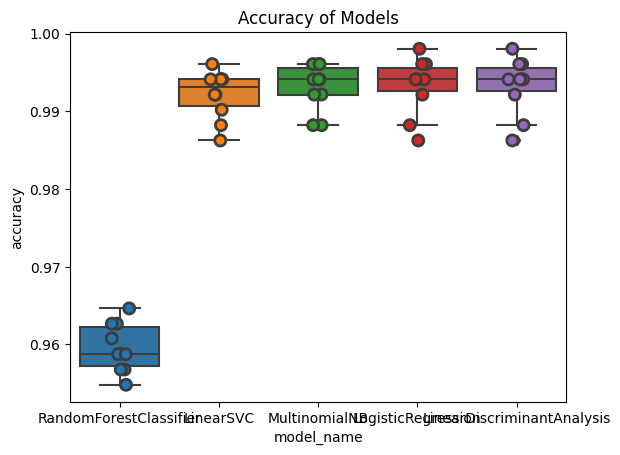

<Figure size 640x480 with 0 Axes>

In [47]:
cv_df = compare_models(X, y, 'Accuracy of Models')

In [49]:
def sample_estimator_sizes(estimator_sizes, X, y):
    estimator_results = []
    for n_estimators in estimator_sizes:
        training_features, test_features, training_target, test_target = train_test_split(X,y,test_size=0.3,random_state=0)
        x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,test_size = 0.3,random_state=12)
        rf_model = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=0,
            verbose=0,
            class_weight='balanced')
        rf_model = rf_model.fit(X=x_train, y=y_train)
        y_pred = rf_model.predict(x_val)
        accuracy = metrics.accuracy_score(y_val, y_pred)
        precision = metrics.precision_score(y_val, y_pred)
        recall = metrics.recall_score(y_val, y_pred)
        # print('number of estimators: ', n_estimators)
        # print('precision: {}'.format(precision), 'recall: {}'.format(recall), 'accuracy: {}'.format(accuracy))

        kfold = KFold(n_splits=10, shuffle=True, random_state=1)
        results = cross_val_score(rf_model, x_train, y_train,scoring='accuracy', cv=kfold)
        # print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

        results_dict = {'estimator': n_estimators, 'kfold_accuracy': results.mean(), 'precision': precision, 'recall': recall, 'accuracy': accuracy, 'f1': metrics.f1_score(y_val, y_pred)}
        estimator_results.append(pd.DataFrame([results_dict]))
    estimator_results_df = pd.concat(estimator_results)
    return estimator_results_df

In [50]:
estimator_results_df = sample_estimator_sizes([10, 50, 100, 200, 300, 400, 500], X, y)

In [51]:
estimator_results_df

,estimator,kfold_accuracy,precision,recall,accuracy,f1
0,10,0.995679,0.989362,0.948980,0.997251,0.968750
0,50,0.996268,1.000000,0.959184,0.998168,0.979167
0,100,0.996464,1.000000,0.959184,0.998168,0.979167
0,200,0.996464,1.000000,0.959184,0.998168,0.979167
0,300,0.996464,1.000000,0.959184,0.998168,0.979167
0,400,0.996464,1.000000,0.959184,0.998168,0.979167
0,500,0.996464,1.000000,0.959184,0.998168,0.979167


In [38]:
subset_predictions_df

,cleaned_magazine_title,ht_generated_title,htid,hdl_link,cleaned_volume,start_issue,end_issue,datetime,dates,issue_number,...,predicted_issue_number,max_issue_length,token_length,tokenized_text,tokenized_text_length,sentences,sentences_length,issue_size,issue_counts,class_numb
0,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1966-04-01,1966-04-01,1966-04-01,April 1966,1.0,...,NaN,0.0,5439,"[!, €, ‘, §4, *, ', 7¢\, ``, ``, '', ``, '', ....",3229,"[!€‘§4*'7¢\ "" """" """".‘_' """"_""‘ """"__,/ """"‘..'~-....",201,42,45123,0
1,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1966-04-01,1966-04-01,1966-04-01,April 1966,1.0,...,NaN,0.0,54,"[AT, ILLINOIS, LIBRARY, OF, THE, UNIVERSITY, U...",7,[AT ILLINOIS LIBRARY OF THE UNIVERSITY URBANA-...,1,42,45123,0
2,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1966-04-01,1966-04-01,1966-04-01,April 1966,1.0,...,NaN,0.0,404,"[#, ', ``, ,, -, --, -LRB-, -RRB-, ., ..., 0CT...",76,"[# ' '' , - -- -LRB- -RRB- ., ... 0CT 1 11 198...",4,42,45123,0
3,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1966-04-01,1966-04-01,1966-04-01,April 1966,1.0,...,NaN,0.0,2,[~L],1,[~L],1,42,45123,0
4,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1966-04-01,1966-04-01,1966-04-01,April 1966,1.0,...,NaN,0.0,28,"[', ._.____, 1, _, fﬂﬁ, ~, », —-—, », -——]",10,[' ._.____ 1 _ fﬂﬁ ~ »—-—»-——],1,42,45123,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1969-12-01,1969-12-01,1969-12-01,December 1969,45,...,NaN,0.0,8,"[!, (, 4, I, s]",5,"[!, (4 I s]",2,45,50222,0
1968,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1969-12-01,1969-12-01,1969-12-01,December 1969,45,...,NaN,0.0,3,"[I, i]",2,[I i],1,45,50222,0
1969,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1969-12-01,1969-12-01,1969-12-01,December 1969,45,...,NaN,0.0,2,[ii],1,[ii],1,45,50222,0
1970,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1969-12-01,1969-12-01,1969-12-01,December 1969,45,...,NaN,0.0,1486,"[!, ``, ``, _, ``, __, ``, ’, ________, “, ', ...",663,"[! "", ""_ ""__ ""’________“ ' '4'_ '5 '_,_ '__ '_...",10,45,50222,0


In [37]:
input_value = combined_df.start_issue.unique().tolist()[0]
most_likely_predicted_issue = combined_df.iloc[(combined_df['predicted_issue_number']-input_value).abs().argsort()[:1]]
top_predictions = predictions[(predictions.max_issue_length == most_likely_predicted_issue.max_issue_length.values[0])]
finalized_issue_length = top_predictions.max_issue_length.unique().tolist()[0]

NameError: name 'predictions' is not defined

In [53]:
def get_finalized_dataset(df, max_issue_length):
    subset_digits = clean_digits(df)
    tqdm.pandas()
    htids = subset_digits.htid.unique().tolist()
    dfs = []
    for htid in tqdm(htids, total=len(htids), desc='Processing digits'):
            subset_df = subset_digits[subset_digits.htid == htid]
            subset_df = get_predicted_page(subset_df, [max_issue_length])
            dfs.append(subset_df)
    combined_subset_digits = pd.concat(dfs)
    combined_subset_digits = combined_subset_digits.reset_index(drop=True)
    digit_cols = combined_subset_digits.columns.tolist()
    digit_cols = [x for x in digit_cols if x not in ['pos', 'count', 'section', 'token']]
    combined_subset_digits = combined_subset_digits[digit_cols]
    cols = list(set(df) & (set(combined_subset_digits)))

    merged_df = pd.merge(df, combined_subset_digits, on=cols, how='left')
    if merged_df['volume_number'].isna().all():
            merged_df = merged_df.drop(columns='volume_number')
    pages_cols = merged_df.columns.tolist()
    holdout_cols = ['section', 'token', 'pos', 'count', 'number', 'implied_zero']
    pages_cols = [x for x in pages_cols if x not in holdout_cols]
    pages_df = merged_df[pages_cols]
    pages_df = pages_df.drop_duplicates()
    groupby_cols = ['cleaned_magazine_title', 'ht_generated_title', 'volume_number', 'htid', 'hdl_link','cleaned_volume', 'start_issue', 'end_issue', 'datetime','dates', 'issue_number', 'type_of_page', 'sequence'] if 'volume_number' in merged_df.columns else ['cleaned_magazine_title', 'ht_generated_title', 'htid', 'hdl_link','cleaned_volume', 'start_issue', 'end_issue', 'datetime','dates', 'issue_number', 'type_of_page', 'sequence']
    final_df = merged_df.groupby(groupby_cols, as_index = False).agg({'token': ' '.join, 'count': list, 'number': list, 'implied_zero': list})
    final_cols = list(set(pages_df) & set(final_df))
    finalized_df = pd.merge(pages_df, final_df, on=final_cols, how='left')
    return finalized_df

In [99]:
finalized_df = get_finalized_dataset(initial_df, finalized_issue_length)

Processing digits: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s]


In [100]:
len(initial_df), len(finalized_df)

(363936, 1941)

In [63]:
# Issue size compared to issue tokens
alt.Chart(issues_df).mark_circle().encode(
    x='issue_counts:Q',
    y='issue_size:Q',
    color=alt.Color('year(datetime):O', scale=alt.Scale(scheme='category20b')),
    # color=alt.Color('magazine_title:O', scale=alt.Scale(scheme='category10')),
).properties(
    width=100,
    height=100
).facet(
    facet='cleaned_magazine_title:O',
    # facet='year(datetime):T',
    columns=3
).resolve_scale(x='independent', y='independent')

alt.FacetChart(...)

In [64]:
len(finalized_df[finalized_df.type_of_page == 'content']), len(finalized_df[finalized_df.type_of_page == 'cover_page']), len(finalized_df[finalized_df.type_of_page == 'toc']), len(finalized_df[finalized_df.predicted_page.notna()])

(1864, 40, 35, 77)

In [68]:
len(finalized_df[finalized_df.type_of_page == 'content'].sample(frac=0.04))

75

In [69]:
content_docs = finalized_df[finalized_df.type_of_page == 'content'].sample(frac=0.04)
cover_docs = finalized_df[finalized_df.type_of_page == 'cover_page']
toc_docs = finalized_df[finalized_df.type_of_page == 'toc']
predicted_docs = finalized_df[finalized_df.predicted_page.notna()]

docs = pd.concat([content_docs, cover_docs, toc_docs, predicted_docs])

In [70]:
remainder_docs = finalized_df[~finalized_df.index.isin(docs.index)]

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer